# SCML: A negotiation game

**Yasser Mohammad and Amy Greenwald**    
**AAAI 2022 Tutorial**


## Installation

To get started, you only need to install NegMAS. It comes with all its dependencies.

In [1]:
# !pip install scml
# agents from SCML 2019 to SCML 2021 (not needed for this tutorial)
# !pip install scml-agents
# Visualizer
# !pip install scml-vis

## Importing what we need

In [2]:
# for reproducibility
import random

random.seed(100)

# importing what we need. As usual, it is not recommended to import *
from scml import *
from negmas import Outcome, ResponseType

And visualization stuff

In [3]:
# setup disply parameters
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(18, 6))        # set figure size
from rich import print
from rich.progress import track
import warnings
warnings.filterwarnings('ignore')

def savefig(name, fig=None):
    if fig is None:
        fig = plt.gcf()
    for ext in ("pdf", "png"):
        plt.savefig(f"{name}.{ext}", pad_inches=0.0, bbox_inches="tight")
        

## Running an SCML World Simulation

In [4]:
def run_simulation(agent_types, plot=True):
    world = SCML2020OneShotWorld(
        **SCML2020OneShotWorld.generate(
            agent_types,
            n_steps=10,
            random_agent_types=True,
        ),
        construct_graphs=True,
    )
    world.run()
    if not plot:
        return world
    world.draw(
        what=["contracts-concluded"],
        steps=(0, world.n_steps - 1),
    )
    return world

Now that we know how to run a simulation, let's write a simple function for evaluating agents in a world

In [5]:
from collections import defaultdict


def evaluate(worlds):
    from scml.scml2020 import is_system_agent

    type_scores = defaultdict(float)
    type_counts = defaultdict(int)
    for world in worlds:
        agent_scores = world.scores()
        for aid, a in world.agents.items():
            if is_system_agent(aid):
                continue
            type_scores[a.type_name.split(":")[-1]] += agent_scores[aid]
            type_counts[a.type_name.split(":")[-1]] += 1
    for t in type_scores.keys():
        type_scores[t] /= type_counts[t]
    plt.bar(x=type_scores.keys(), height=type_scores.values())
    return type_scores

Let's run a negotiation with two of the built-in agents

defaultdict(float,
            {'GreedyOneShotAgent': 1.2723620282660666,
             'RandomOneShotAgent': 0.5589152025370039})

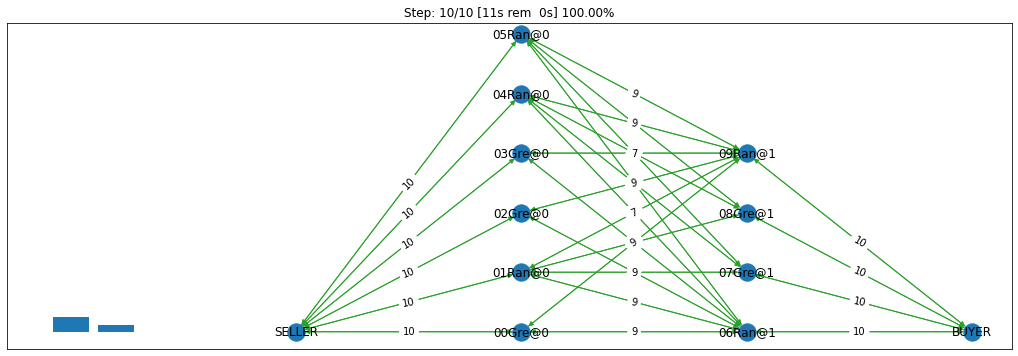

In [6]:
evaluate([run_simulation([RandomOneShotAgent, GreedyOneShotAgent])])


## Developing our own agent

Let's start with an agent that *literally* does nothing to see the interface

In [7]:
class MyOneShotDoNothing(OneShotAgent):
    def propose(self, negotiator_id, state):
        return None

    def respond(self, negotiator_id, state, offer):
        return ResponseType.END_NEGOTIATION

and evaluate it

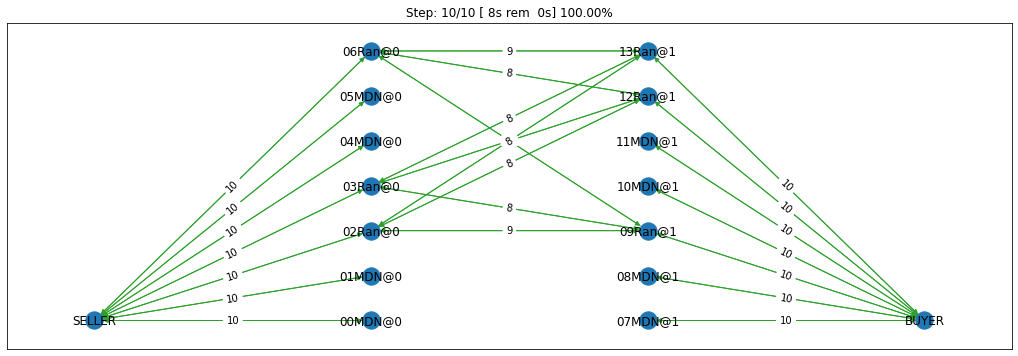

In [8]:
world = run_simulation([MyOneShotDoNothing, RandomOneShotAgent])

We can see some of the statics collected

<AxesSubplot:>

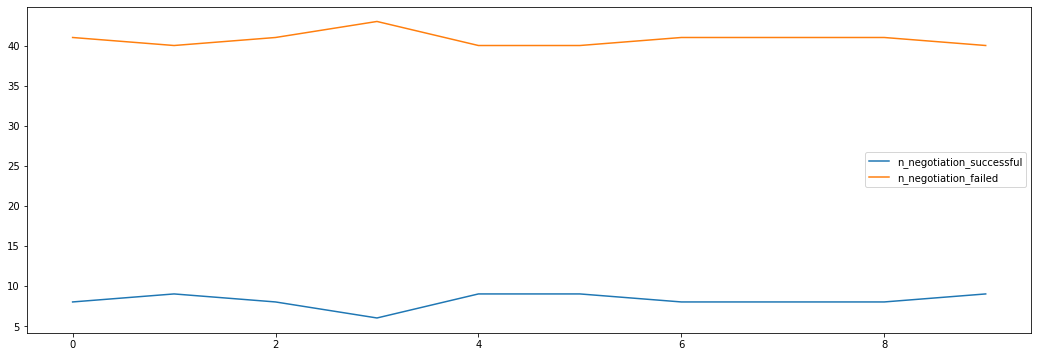

In [9]:
world.stats_df.plot(y=["n_negotiation_successful", "n_negotiation_failed"])

Now, let's try a really simple agent.

- Assume that you will be getting just one agreement every step.
- Try to get the best agreement using a time-based concession strategy
- Once you get an agreement, end all others

In [10]:
from negmas import PolyAspiration

class MyConcedingAgent(OneShotAgent):
    """ Concedes slowly on every negotiation assuming it will be the only one with agreement. """

    asp = PolyAspiration(1.0, "boulware")
    has_agreement = False

    def propose(self, negotiator_id, state):
        u = self.asp.utility_at(state.relative_time)
        inv = self.ufun.invert()
        candidates = inv.within_fractions((u, 1.0))
        return candidates[0] if candidates else inv.best

    def respond(self, negotiator_id, state, offer):
        if self.has_agreement:
            return ResponseType.END_NEGOTIATION
        u = self.asp.utility_at(state.relative_time)
        if self.ufun(offer) >= u:
            return ResponseType.ACCEPT_OFFER
        return ResponseType.REJECT_OFFER

    def on_negotiation_success(self, contract, mechanism) -> None:
        self.has_agreement = True

    def step(self):
        self.has_agreement = False

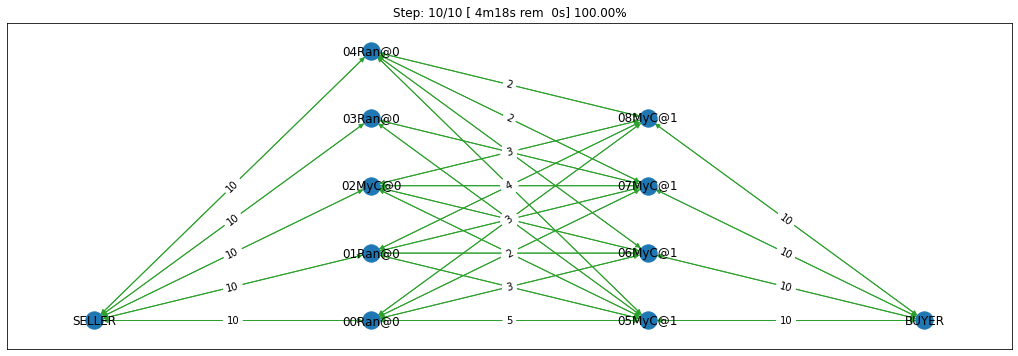

In [11]:
world = run_simulation([MyConcedingAgent, RandomOneShotAgent, GreedyOneShotAgent])

And we can look again at the success rate of negotiations

<AxesSubplot:>

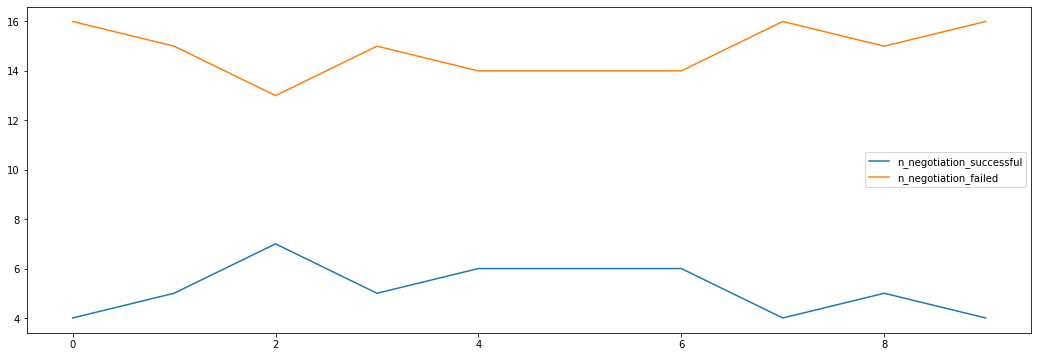

In [12]:

world.stats_df.plot(y=["n_negotiation_successful", "n_negotiation_failed"])

Let's write a simple function to evaluate different agents in the world

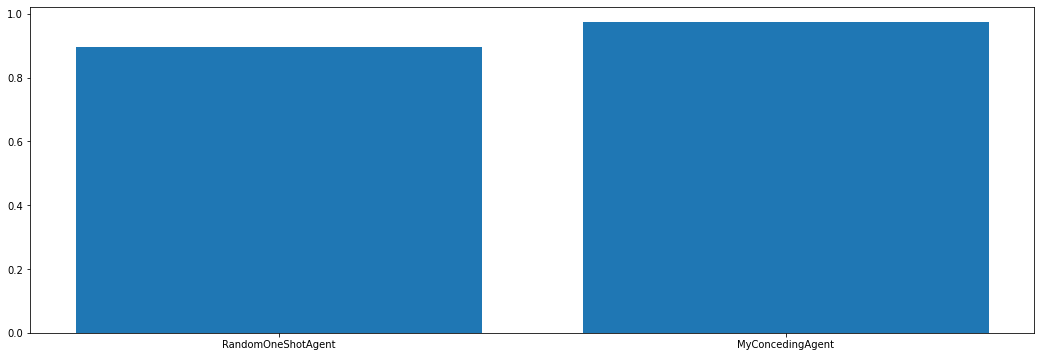

In [13]:
scores = evaluate([world])

Output()

defaultdict(float,
            {'MyConcedingAgent': 0.7938886092717656,
             'RandomOneShotAgent': 0.4106135230197311,
             'GreedyOneShotAgent': 1.1324879535309704})

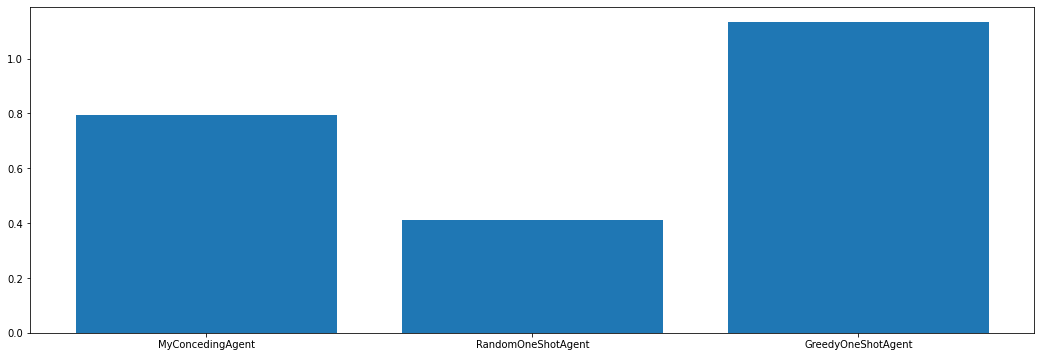

In [14]:
worlds = [
    run_simulation(
        [MyConcedingAgent, GreedyOneShotAgent, RandomOneShotAgent], plot=False
    )
    for _ in track(range(50))
]
evaluate(worlds)
